In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import spacy
import string
import nltk
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity

In [89]:
from spacy.cli import download
print(download('en_core_web_sm'))

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
None


In [90]:
nlp = spacy.load('en_core_web_sm',  disable=["parser", "ner"])

In [2]:
data = pd.read_csv('./Data/interactions_train.csv')

In [3]:
data

,user_id,recipe_id,date,rating,u,i
0,2046,4684,2000-02-25,5.0,22095,44367
1,2046,517,2000-02-25,5.0,22095,87844
2,1773,7435,2000-03-13,5.0,24732,138181
3,1773,278,2000-03-13,4.0,24732,93054
4,2046,3431,2000-04-07,5.0,22095,101723
...,...,...,...,...,...,...
698896,926904,457971,2018-12-18,5.0,13681,141067
698897,2002312797,27208,2018-12-18,5.0,14897,99787
698898,1290903,131607,2018-12-18,5.0,11605,76163
698899,226867,363072,2018-12-18,5.0,3604,29101


In [4]:
data.describe()

,user_id,recipe_id,rating,u,i
count,6.989010e+05,698901.000000,698901.000000,698901.000000,698901.000000
mean,1.247694e+07,156173.409849,4.574090,4249.330271,87519.330993
std,1.525031e+08,126594.880211,0.959022,5522.602821,51290.370370
min,1.533000e+03,38.000000,0.000000,0.000000,0.000000
25%,1.059880e+05,53169.000000,4.000000,455.000000,42988.000000
50%,2.301020e+05,116484.000000,5.000000,1737.000000,87424.000000
75%,4.801950e+05,234516.000000,5.000000,5919.000000,131731.000000
max,2.002313e+09,537458.000000,5.000000,25075.000000,178262.000000


<Axes: title={'center': 'Train Ratings'}>

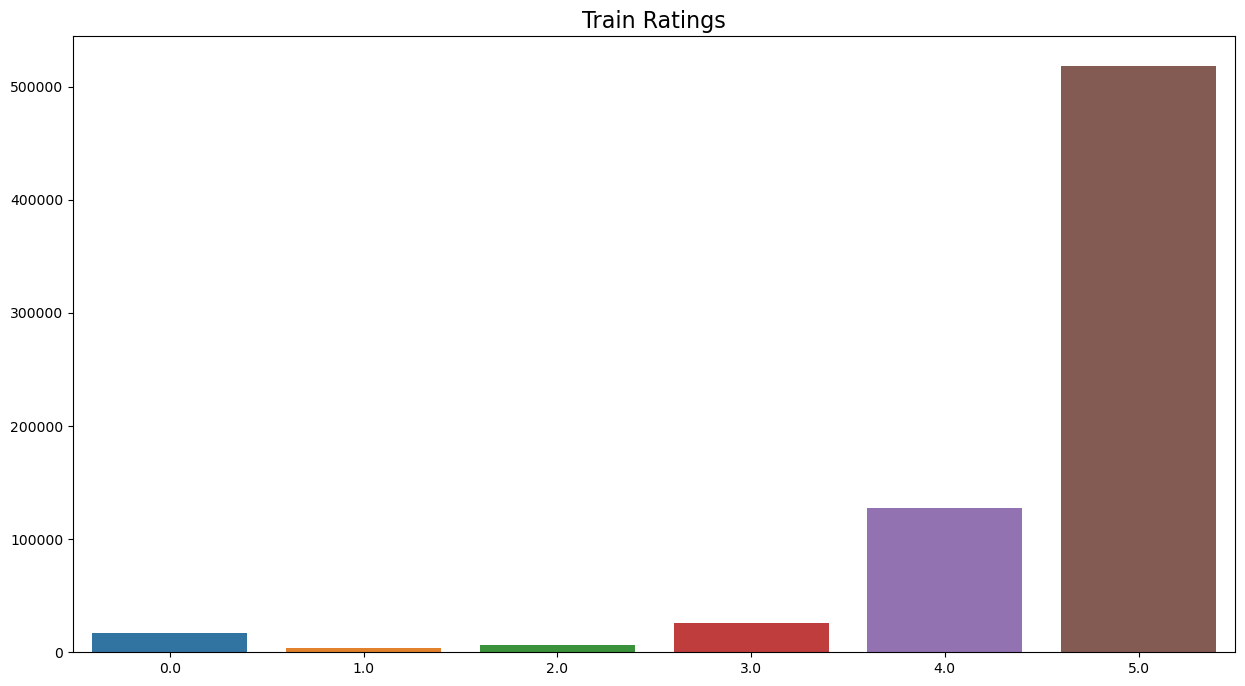

In [18]:
plt.figure(figsize=(15,8))
plt.title('Train Ratings', fontsize = 16)

train_dis = data['rating'].value_counts().sort_values()
sns.barplot(x = list(train_dis.keys()), y = train_dis.values)

In [5]:
interaction_data = pd.read_csv('./Data/RAW_interactions.csv')

In [6]:
interaction_data

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."
...,...,...,...,...,...
1132362,116593,72730,2003-12-09,0,Another approach is to start making sauce with...
1132363,583662,386618,2009-09-29,5,These were so delicious! My husband and I tru...
1132364,157126,78003,2008-06-23,5,WOW! Sometimes I don't take the time to rate ...
1132365,53932,78003,2009-01-11,4,Very good! I used regular port as well. The ...


In [51]:
interactions_combined = data.merge(interaction_data[['recipe_id','review']], how='inner', on='recipe_id', sort=True)

In [52]:
interactions_combined

,user_id,recipe_id,date,rating,u,i,review
0,596506,38,2008-02-13,5.0,15830,16791,"Yummy, yummy, yummy! I am a big fan of fruit a..."
1,596506,38,2008-02-13,5.0,15830,16791,very good!! the directions were alittle weird ...
2,596506,38,2008-02-13,5.0,15830,16791,This does taste great! I think the recipe need...
3,596506,38,2008-02-13,5.0,15830,16791,Tasty and refreshing! I love the creamy flavor...
4,1060485,38,2009-01-15,4.0,643,16791,"Yummy, yummy, yummy! I am a big fan of fruit a..."
...,...,...,...,...,...,...,...
44514516,226863,536729,2018-10-06,4.0,267,116869,Colors are great in this salad. For those that...
44514517,482376,536990,2018-09-26,5.0,247,103563,This fit the bill perfectly on a busy day/nigh...
44514518,204024,537175,2018-11-22,5.0,349,78714,Loved these warm delicious rolls. So easy to m...
44514519,226867,537319,2018-11-06,3.0,3604,115103,"I'm so sorry, Bonnie - but I followed the dire..."


<Axes: title={'center': 'Combined Interactions'}>

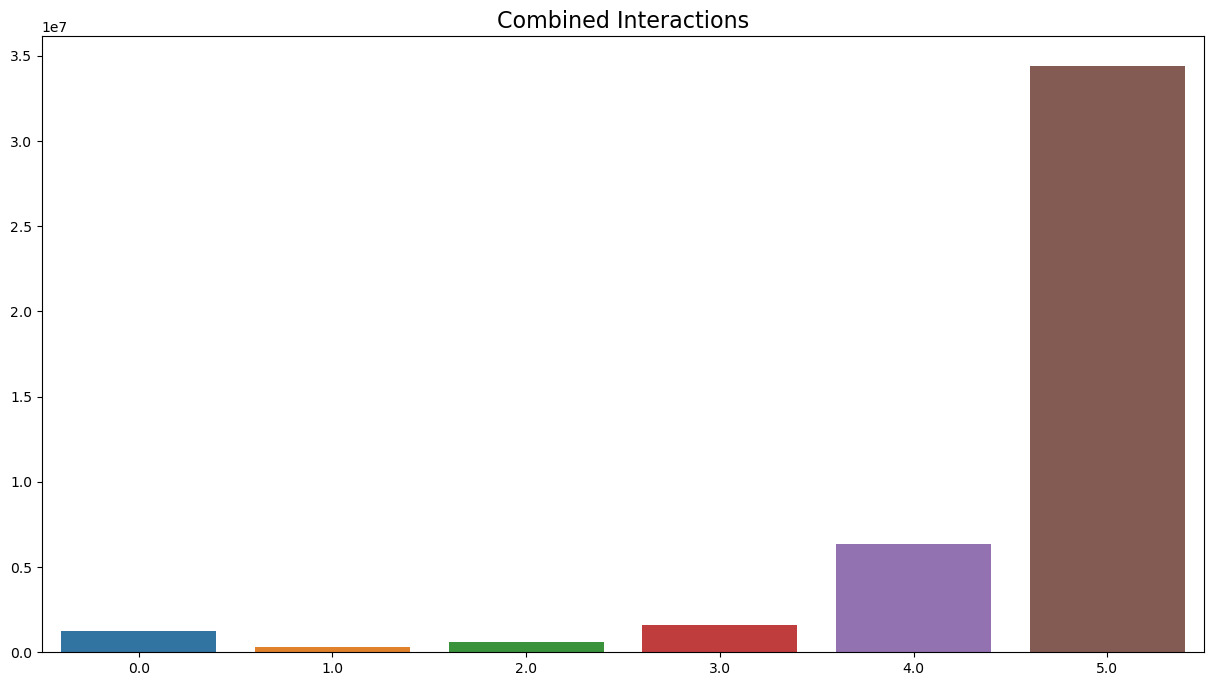

In [19]:
plt.figure(figsize=(15,8))
plt.title('Combined Interactions', fontsize = 16)

int_dis = interactions_combined['rating'].value_counts().sort_values()
sns.barplot(x = list(int_dis.keys()), y = int_dis.values)

In [53]:
interactions_combined_sub = interactions_combined.sample(n = 100000, random_state = 42)

In [64]:
interactions_combined_sub

,user_id,recipe_id,date,rating,u,i,review
899020,2640312,2886,2018-07-16,0.0,18989,106975,A lovely recipe. I made it exactly as specifie...
21220879,176481,53941,2009-11-02,5.0,548,137897,Absolutely delicious! I figured I wouldn't be...
21514322,341148,54257,2007-10-21,5.0,20732,52334,What can I say that hasn't been said. With 497...
38642518,1584433,129926,2010-06-28,5.0,7956,19812,Made this tonight and even my picky eaters sai...
9278926,552052,27208,2008-12-08,3.0,8683,99787,I made this over the weekend with a top sirloi...
...,...,...,...,...,...,...,...
38151313,186070,126035,2005-06-21,5.0,2423,168049,These are delicious! I made mine also with hal...
18294833,212151,42169,2006-10-24,5.0,17667,147615,Thank you Marie for a awesome recipe. I paire...
19531987,698759,47391,2010-04-18,5.0,12135,176716,The crust is wonderful. Can&#039;t wait to us...
11653836,92886,29679,2008-08-22,5.0,363,73956,Very good but ohhh so rich! I added about a c...


In [23]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aunib\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [32]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aunib\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\aunib\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

In [24]:
from nltk.corpus import stopwords
stopwords_set = set(stopwords.words("english"))
print(stopwords_set)

{'here', "should've", "mustn't", 'its', 'no', 'he', 'where', 'than', 'now', "didn't", 'shan', 'then', "you're", 'my', 'into', 'above', 'aren', 'doesn', 'which', 'over', 'with', 'after', 'wasn', 'who', 'ours', 'at', 'during', 'had', 'was', 'myself', 'but', 'under', "shan't", 'because', 'not', 'why', 'does', 'hasn', 'this', 'out', 'of', 'about', 'down', 'what', 'they', 'o', "isn't", "that'll", 'while', 'him', 'd', 'should', 'themselves', 'to', 'those', "you'd", 'herself', 're', "wouldn't", 'only', 'don', "won't", "she's", 'as', 'some', 'very', 'until', 'both', 'hadn', 'needn', 'and', 'our', 'her', 'their', 'mustn', 'most', "don't", 'shouldn', 'on', 'doing', 'against', 'that', 'the', 't', 'is', 'have', 'few', 'before', 'there', 'nor', 'each', 'through', 'are', 'so', 'been', "it's", "doesn't", "aren't", 'when', "you'll", 'if', 'can', 'up', "shouldn't", 'mightn', 'ourselves', 'too', 'them', 'yourselves', 'haven', 'theirs', 've', "hadn't", 'were', 's', 'any', 'y', 'hers', 'ma', 'these', 'or'

In [70]:
def preprocess(sent):
    sent = sent.lower()
    pattern = '[^\w\s]'
    sent = re.sub(pattern, '', sent)
    return sent

In [71]:
interactions_combined_sub.review = interactions_combined_sub.review.astype(str)

In [72]:
interactions_combined_sub['review'] = interactions_combined_sub['review'].apply(preprocess)

In [73]:
interactions_combined_sub['review']

899020      a lovely recipe i made it exactly as specified...
21220879    absolutely delicious  i figured i wouldnt be a...
21514322    what can i say that hasnt been said with 497 r...
38642518    made this tonight and even my picky eaters sai...
9278926     i made this over the weekend with a top sirloi...
                                  ...                        
38151313    these are delicious i made mine also with half...
18294833    thank you marie for a awesome recipe  i paired...
19531987    the crust is wonderful  can039t wait to use it...
11653836    very good but ohhh so rich  i added about a cu...
34787080    to make the best pancakes or any food it all b...
Name: review, Length: 100000, dtype: object

In [74]:
def stopwords(sent):
    sent = sent.lower()
    words = word_tokenize(sent)
    text_nostopwords = " ".join([each_word for each_word in words if each_word not in stopwords_set])
    return sent

In [77]:
interactions_combined_sub.review = interactions_combined_sub.review.astype(str)

In [78]:
interactions_combined_sub['review'] = interactions_combined_sub['review'].apply(stopwords)

In [79]:
interactions_combined_sub['review']

899020      a lovely recipe i made it exactly as specified...
21220879    absolutely delicious  i figured i wouldnt be a...
21514322    what can i say that hasnt been said with 497 r...
38642518    made this tonight and even my picky eaters sai...
9278926     i made this over the weekend with a top sirloi...
                                  ...                        
38151313    these are delicious i made mine also with half...
18294833    thank you marie for a awesome recipe  i paired...
19531987    the crust is wonderful  can039t wait to use it...
11653836    very good but ohhh so rich  i added about a cu...
34787080    to make the best pancakes or any food it all b...
Name: review, Length: 100000, dtype: object

In [81]:
def lemmatize(text):
    sent = []
    doc = nlp(text)
    for token in doc:
        sent.append(token.lemma_)
    return " ".join(sent)

In [91]:
interactions_combined_sub.review = interactions_combined_sub.review.astype(str)

In [92]:
interactions_combined_sub['review'] = interactions_combined_sub['review'].apply(lemmatize)

In [93]:
interactions_combined_sub['review']

899020      a lovely recipe I make it exactly as specify e...
21220879    absolutely delicious   I figure I would not be...
21514322    what can I say that have not be say with 497 r...
38642518    make this tonight and even my picky eater say ...
9278926     I make this over the weekend with a top sirloi...
                                  ...                        
38151313    these be delicious I make mine also with half ...
18294833    thank you marie for a awesome recipe   I pair ...
19531987    the crust be wonderful   can039 t wait to use ...
11653836    very good but ohhh so rich   I add about a cup...
34787080    to make the good pancake or any food it all be...
Name: review, Length: 100000, dtype: object

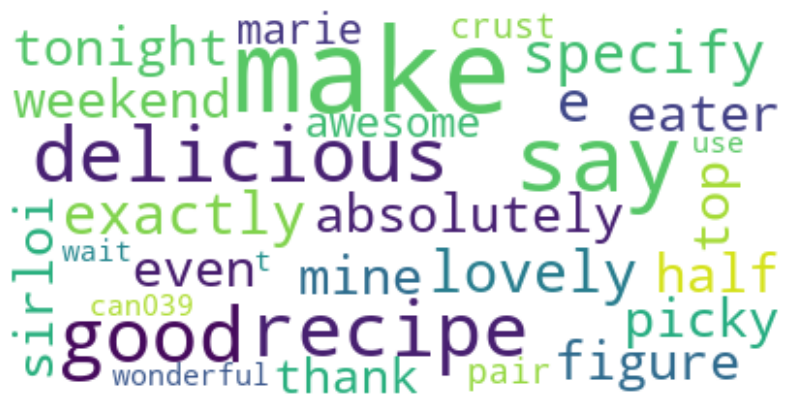

In [95]:
stopwords_wordcloud = set(STOPWORDS)
wordcloud = WordCloud(max_font_size=60, max_words=30, 
                      background_color="white", random_state=42, 
                      stopwords=stopwords_wordcloud).generate(str(interactions_combined_sub['review']))
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [96]:
interactions_combined_sub

,user_id,recipe_id,date,rating,u,i,review
899020,2640312,2886,2018-07-16,0.0,18989,106975,a lovely recipe I make it exactly as specify e...
21220879,176481,53941,2009-11-02,5.0,548,137897,absolutely delicious I figure I would not be...
21514322,341148,54257,2007-10-21,5.0,20732,52334,what can I say that have not be say with 497 r...
38642518,1584433,129926,2010-06-28,5.0,7956,19812,make this tonight and even my picky eater say ...
9278926,552052,27208,2008-12-08,3.0,8683,99787,I make this over the weekend with a top sirloi...
...,...,...,...,...,...,...,...
38151313,186070,126035,2005-06-21,5.0,2423,168049,these be delicious I make mine also with half ...
18294833,212151,42169,2006-10-24,5.0,17667,147615,thank you marie for a awesome recipe I pair ...
19531987,698759,47391,2010-04-18,5.0,12135,176716,the crust be wonderful can039 t wait to use ...
11653836,92886,29679,2008-08-22,5.0,363,73956,very good but ohhh so rich I add about a cup...


In [97]:
tfidf = TfidfVectorizer(min_df=5, max_df=0.95, stop_words='english', ngram_range=(2,2))

In [98]:
X = tfidf.fit_transform(interactions_combined_sub['review'])

y = interactions_combined_sub['rating']

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [102]:
print("Train shapes:", X_train.shape, y_train.shape)
print("Test shapes:", X_test.shape, y_test.shape)

Train shapes: (80000, 67038) (80000,)
Test shapes: (20000, 67038) (20000,)


In [117]:
def evaluation_scores(classifier, X_test, y_test):

    y_pred = classifier.predict(X_test)

    conf_m = confusion_matrix(y_test, y_pred)

    print("Visualizing the Confusion Matrix with a Heatmap")
    print("\n")
    print("*"*50)
    # Visualize Confusion Matrix with heatmap
    fig, ax = plt.subplots(figsize=(6, 6))
    ax = sns.heatmap(confusion_matrix(y_test, y_pred),
                  annot=True,
                  cbar=False,
                  cmap="RdYlGn", fmt = '0.1f')
    plt.xlabel("Actual label")
    plt.ylabel("Predicted label")
    plt.show()
    print("*"*50)
    print("\n")

    # Calculating Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracy = round(accuracy,2)

    print("Evaluation Score Summary")
    print('-'*50)
    print(f'Accuracy Score: {round(accuracy,2)}')
    print('-'*50)

    evaluation_metrics = []
    evaluation_metrics.append(accuracy)

    return evaluation_metrics

In [118]:
lr = LogisticRegression(random_state=42, solver='liblinear').fit(X_train, y_train)

Visualizing the Confusion Matrix with a Heatmap


**************************************************


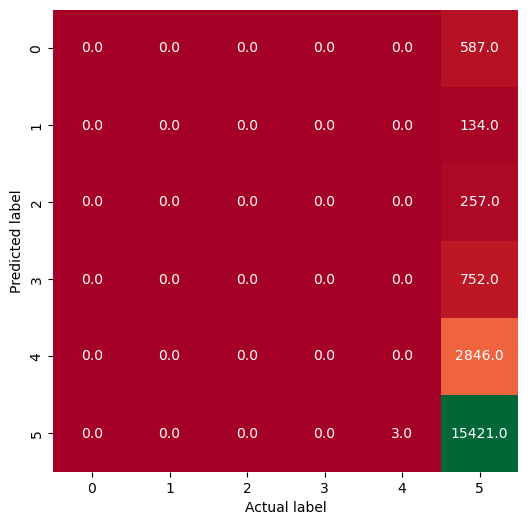

**************************************************


Evaluation Score Summary
--------------------------------------------------
Accuracy Score: 0.77
--------------------------------------------------


In [119]:
lr_metrics = evaluation_scores(lr, X_test, y_test)